## Load everything

In [10]:
import yaml
import sys
import traceback
import logging
import contextlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

%matplotlib inline

from tqdm.notebook import tqdm
from typing import *

%load_ext autoreload
%autoreload 2

import os
current_dir = os.getcwd()
os.chdir("../src")
from dqnroute import *
os.chdir(current_dir)

logger = logging.getLogger(DQNROUTE_LOGGER)
TORCH_MODELS_DIR = '../torch_models'
LOG_DATA_DIR = '../logs/runs'
np.set_printoptions(linewidth=500)

_legend_txt_replace = {
    'networks': {
        'link_state': 'Shortest paths',
        'simple_q': 'Q-routing',
        'pred_q': 'PQ-routing',
        'glob_dyn': 'Global-dynamic',
        'dqn': 'DQN',
        'dqn_oneout': 'DQN (1-out)',
        'dqn_emb': 'DQN-LE',
        'centralized_simple': 'Centralized control'
    },
    'conveyors': {
        'link_state': 'Vyatkin-Black',
        'simple_q': 'Q-routing',
        'pred_q': 'PQ-routing',
        'glob_dyn': 'Global-dynamic',
        'dqn': 'DQN',
        'dqn_oneout': 'DQN (1-out)',
        'dqn_emb': 'DQN-LE',
        'centralized_simple': 'BSR'
    }
}

_targets = {'time': 'avg','energy': 'sum', 'collisions': 'sum'}

_ylabels = {
    'time': 'Mean delivery time',
    'energy': 'Total energy consumption',
    'collisions': 'Cargo collisions'
}

def print_sums(df):
    types = set(df['router_type'])
    for tp in types:
        x = df.loc[df['router_type']==tp, 'count'].sum()
        txt = _legend_txt_replace.get(tp, tp)
        print('  {}: {}'.format(txt, x))

def plot_data(data, meaning='time', figsize=(15,5), xlim=None, ylim=None,
              xlabel='Simulation time', ylabel=None,
              font_size=14, title=None, save_path=None,
              draw_collisions=False, context='networks', **kwargs):
    if 'time' not in data.columns:
        datas = split_dataframe(data, preserved_cols=['router_type', 'seed'])
        for tag, df in datas:
            if tag == 'collisions' and not draw_collisions:
                print('Number of collisions:')
                print_sums(df)
                continue
                
            xlim = kwargs.get(tag+'_xlim', xlim)
            ylim = kwargs.get(tag+'_ylim', ylim)
            save_path = kwargs.get(tag+'_save_path', save_path)
            plot_data(df, meaning=tag, figsize=figsize, xlim=xlim, ylim=ylim,
                      xlabel=xlabel, ylabel=ylabel, font_size=font_size,
                      title=title, save_path=save_path, context='conveyors')
        return 
    
    target = _targets[meaning]
    if ylabel is None:
        ylabel = _ylabels[meaning]
        
    fig = plt.figure(figsize=figsize)
    ax = sns.lineplot(x='time', y=target, hue='router_type', data=data,
                      err_kws={'alpha': 0.1})
    
    handles, labels = ax.get_legend_handles_labels()
    new_labels = list(map(lambda l: _legend_txt_replace[context].get(l, l), labels[1:]))
    ax.legend(handles=handles[1:], labels=new_labels, fontsize=font_size)
    
    ax.tick_params(axis='both', which='both', labelsize=int(font_size*0.75))
        
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    if title is not None:
        ax.set_title(title)
    
    ax.set_xlabel(xlabel, fontsize=font_size)
    ax.set_ylabel(ylabel, fontsize=font_size)
    
    plt.show(fig)
    
    if save_path is not None:
        fig.savefig('../img/' + save_path, bbox_inches='tight')

def split_data(dct):
    results = []
    
    def add_res(i, key, val):
        while len(results) <= i:
            results.append({})
        results[i][key] = val
    
    for (key, vals) in dct.items():
        for (i, val) in enumerate(vals):
            add_res(i, key, val)
    return tuple(results)
    
def combine_launch_data(launch_data):
    dfs = []
    for (job_id, data) in launch_data.items():
        router_type, seed = un_job_id(job_id)
        df = data.copy()
        add_cols(df, router_type=router_type, seed=seed)
        dfs.append(df)
    return pd.concat(dfs, axis=0)

class DummyTqdmFile(object):
    """Dummy file-like that will write to tqdm"""
    file = None
    def __init__(self, file):
        self.file = file

    def write(self, x):
        # Avoid print() second call (useless \n)
        if len(x.rstrip()) > 0:
            tqdm.write(x, file=self.file)

    def flush(self):
        return getattr(self.file, "flush", lambda: None)()

@contextlib.contextmanager
def std_out_err_redirect_tqdm():
    orig_out_err = sys.stdout, sys.stderr
    try:
        sys.stdout, sys.stderr = map(DummyTqdmFile, orig_out_err)
        yield orig_out_err[0]
    # Relay exceptions
    except Exception as exc:
        raise exc
    # Always restore sys.stdout/err if necessary
    finally:
        sys.stdout, sys.stderr = orig_out_err

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Run simulation

In [32]:
def run_single(file: str, router_type: str, random_seed: int, **kwargs):
    job_id = mk_job_id(router_type, random_seed)
    with tqdm(desc=job_id) as bar:
        queue = DummyProgressbarQueue(bar)
        runner = ConveyorsRunner(run_params=file, router_type=router_type,
                                 random_seed=random_seed, progress_queue=queue, **kwargs)
        event_series = runner.run(**kwargs)
    return event_series, runner

#scenario = '../launches/conveyor_energy_test.yaml'
#scenario = '../launches/conveyor_cyclic_energy_test.yaml'
scenario = '../launches/conveyor_cyclic2_energy_test.yaml'

event_series, runner = run_single(file=scenario, router_type='dqn_emb', progress_step=500,
                                  ignore_saved=[True], random_seed=44)

[ World      : 3975.697481461566s ] collision detected: (#204; 20m) with (#201; 19.559m) on conv 1
[ World      : 4287.779257958406s ] collision detected: (#220; 10m) with (#217; 9.754m) on conv 3
[ World      : 4590.877701939624s ] collision detected: (#235; 10m) with (#232; 10.999m) on conv 3
[ World      : 4892.821883753559s ] collision detected: (#250; 10m) with (#247; 10.998m) on conv 3
[ World      : 5274.1504463469655s ] collision detected: (#269; 10m) with (#266; 9.79m) on conv 3
[ World      : 7146.239741845569s ] collision detected: (#362; 10m) with (#359; 9.792m) on conv 3
[ World      : 12848.009131822597s ] collision detected: (#654; 10m) with (#651; 9.102m) on conv 3
[ World      : 13624.108757079943s ] collision detected: (#693; 10m) with (#690; 9.011m) on conv 3
[ World      : 13962.408226490012s ] collision detected: (#710; 10m) with (#707; 9.102m) on conv 3
[ World      : 22941.70973886602s ] collision detected: (#1161; 10m) with (#1158; 9.222m) on conv 3



## Explore the graph and routers assigned to nodes

In [33]:
from ml_util import Util

class RouterGraph:
    def __init__(self, runner):
        # 1. explore
        print(type(runner.world).mro()[:-1])
        self.graph = runner.world.topology_graph
        self.routers = runner.world.handlers
        self.q_network = None
        for node_key, router_keeper in self.routers.items():
            print("node", node_key, type(router_keeper).__name__)
            out_nodes = self.get_out_nodes(node_key)
            for router_key, router in router_keeper.routers.items():
                print("    router", router_key, type(router).__name__)
                self.q_network = router.brain
                self.node_repr = router._nodeRepr
                #print("    directed edges:", out_edges)
                print("    directed neighbor nodes:", out_nodes)
                neighbor_routers = [list(self.routers[node].routers.keys()) if node in self.routers.keys() else []
                                    for node in out_nodes]
                neighbor_routers = sum(neighbor_routers, [])
                print("    directed neighbor routers:", neighbor_routers)
        self.q_network.ff_net = Util.conditional_to_cuda(self.q_network.ff_net)
        
        # 2. load nodes and sort them
        self.node_keys: List[AgentId] = list(self.graph.nodes)
        self.node_keys = [(0, key) for key in self.node_keys if key[0] == "source"] \
                       + [(2, key) for key in self.node_keys if key[0] == "sink"] \
                       + [(1, key) for key in self.node_keys if key[0] not in ["source", "sink"]]
        self.node_keys = [x[1] for x in sorted(self.node_keys)]
        self.node_keys_to_indices = {key: i for i, key in enumerate(self.node_keys)}
        self.indices_to_node_keys = {i: key for i, key in enumerate(self.node_keys)}
        
        # 3. compute reachability matrix
        self.reachable = self._compute_reachability_matrix()
        
        # 4. list of nodes of particulat types
        nodes_of_type = lambda s: [node_key for node_key in self.node_keys if node_key[0] == s]
        self.sources = nodes_of_type("source")
        self.sinks = nodes_of_type("sink")
        self.diverters = nodes_of_type("diverter")
    
    def q_forward(self, current_embedding, sink_embedding, neighbor_embedding):
        return self.q_network.forward(current_embedding, sink_embedding, neighbor_embedding)
    
    def _compute_reachability_matrix(self):
        # 1. initialize with self-reachability
        reachable = {(k1, k2): k1 == k2 for k1 in self.node_keys for k2 in self.node_keys}
        # 2. add transitions
        for from_node in self.node_keys:
            for to_node in self.get_out_nodes(from_node):
                reachable[from_node, to_node] = True
        # 3. close with Floyd-Warshall
        for k in self.node_keys:
            for i in self.node_keys:
                for j in self.node_keys:
                    reachable[i, j] |= reachable[i, k] and reachable[k, j]
        return reachable
    
    def get_out_nodes(self, node_key: AgentId):
        return sorted([e[1] for e in self.graph.out_edges(node_key)])
    
    def get_out_node_indices(self, node_index: int):
        return [self.node_keys_to_indices[key]
                for key in self.get_out_nodes(self.indices_to_node_keys[node_index])]
    
    def print_reachability_matrix(self):
        for from_node in self.node_keys:
            for to_node in self.node_keys:
                print(1 if self.reachable[from_node, to_node] else 0, end="")
            print(f" # from {from_node}")
    
    def _get_final_router(self, node_key: AgentId) -> dict:
        """Returns dict{where_to_go: router_id}."""
        # if "source", "conveyor", "junction": return find_neighbors of the only child
        # if "sink", "diverter": it contains a router to return
        if node_key[0] in ["source", "conveyor", "junction"]:
            out_nodes = self.get_out_nodes(node_key)
            assert len(out_nodes) == 1, out_nodes
            return self._get_final_router(out_nodes[0])
        elif node_key[0] in ["sink", "diverter"]:
            r = list(self.routers[node_key].routers.keys())
            assert len(r) == 1
            return r[0]
        else:
            raise AssertionError(f"Unexpected node type: {node_key[0]}")
    
    def _get_router_embedding(self, router: AgentId):
        return Util.conditional_to_cuda(torch.FloatTensor([self.node_repr(router[1])]))
    
    def node_to_embeddings(self, current_node: AgentId, sink: AgentId) -> Tuple[torch.tensor, List[torch.tensor]]:
        current_router = list(self.routers[current_node].routers.keys())
        assert len(current_router) == 1
        current_router = current_router[0]
        current_embedding = self._get_router_embedding(current_router)
        if current_node[0] == "sink":
            out_nodes = []
        else:
            out_nodes = self.get_out_nodes(current_node)
            # leave only nodes from which the sink is reachable
            out_nodes = [out_node for out_node in out_nodes if self.reachable[out_node, sink]]
        out_embeddings = [self._get_router_embedding(self._get_final_router(out_node)) for out_node in out_nodes] 
        return current_embedding, out_nodes, out_embeddings

g = RouterGraph(runner)

[<class 'dqnroute.simulation.conveyors.ConveyorsEnvironment'>, <class 'dqnroute.simulation.common.MultiAgentEnv'>, <class 'dqnroute.utils.HasLog'>, <class 'dqnroute.utils.HasTime'>]
node ('sink', 0) RouterSink
    router ('router', 12) DQNRouterEmbConveyor
    directed neighbor nodes: []
    directed neighbor routers: []
node ('sink', 1) RouterSink
    router ('router', 13) DQNRouterEmbConveyor
    directed neighbor nodes: []
    directed neighbor routers: []
node ('source', 0) RouterSource
    router ('router', 14) DQNRouterEmbConveyor
    directed neighbor nodes: [('junction', 4)]
    directed neighbor routers: []
node ('source', 1) RouterSource
    router ('router', 15) DQNRouterEmbConveyor
    directed neighbor nodes: [('junction', 8)]
    directed neighbor routers: []
node ('conveyor', 0) SimpleRouterConveyor
    router ('router', 10) DQNRouterEmbConveyor
    directed neighbor nodes: []
    directed neighbor routers: []
node ('conveyor', 1) SimpleRouterConveyor
    router ('router

## Find the reachability matrix of the graph

In [34]:
g.print_reachability_matrix()

1011111111111111 # from ('source', 0)
0111111111111111 # from ('source', 1)
0011111111111111 # from ('diverter', 0)
0011111111111111 # from ('diverter', 1)
0011111111111111 # from ('diverter', 2)
0011111111111111 # from ('junction', 0)
0011111111111111 # from ('junction', 1)
0011111111111111 # from ('junction', 2)
0011111111111111 # from ('junction', 3)
0011111111111111 # from ('junction', 4)
0000000000111010 # from ('junction', 5)
0000000000011010 # from ('junction', 6)
0000000000001010 # from ('junction', 7)
0011111111111111 # from ('junction', 8)
0000000000000010 # from ('sink', 0)
0000000000000001 # from ('sink', 1)


## Visualize graph

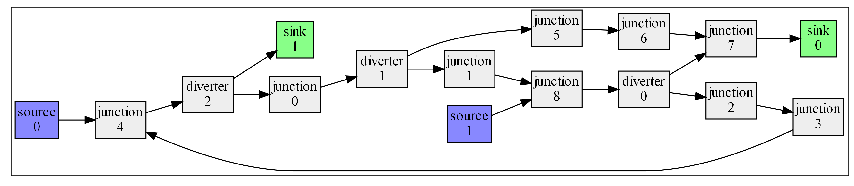

In [35]:
import pygraphviz as pgv

gv_graph = pgv.AGraph(directed=True)

def get_gv_node_name(node_key: AgentId):
    return f"{node_key[0]}\n{node_key[1]}"

for i, node_key in g.indices_to_node_keys.items():
    gv_graph.add_node(i)
    n = gv_graph.get_node(i)
    n.attr["label"] = get_gv_node_name(node_key)
    n.attr["shape"] = "box"
    n.attr["style"] = "filled"
    n.attr["fixedsize"] = "true"
    if node_key[0] == "source":
        n.attr["fillcolor"] = "#8888FF"
        n.attr["width"] = "0.6"
    elif node_key[0] == "sink":
        n.attr["fillcolor"] = "#88FF88"
        n.attr["width"] = "0.5"
    else:
        n.attr["fillcolor"] = "#EEEEEE"
        n.attr["width"] = "0.7"

for from_node in g.node_keys:
    for to_node in g.get_out_nodes(from_node):
        gv_graph.add_edge(g.node_keys_to_indices[from_node], g.node_keys_to_indices[to_node])

prefix = "../img/tmp."
gv_graph.write(prefix + "gv")
for path in [prefix + "png", prefix + "pdf"]:
    gv_graph.draw(path, prog="dot", args="-Gdpi=300 -Gmargin=0 -Grankdir=LR")
fig, ax = plt.subplots(figsize=(15, 15))
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
image = plt.imread(prefix + "png")
plt.imshow(image);

### Test routing from each source to each sink

* Routers are different from graph nodes
* At junctions, there are routers that do not have choice
* Other routeres are at diverters and they have only two choices
* During the real system operation, routeres behave stochastically

In [36]:
for source in g.sources:
    for sink in g.sinks:
        print(f"Testing delivery from {source} to {sink}...")
        current_node = source
        visited_nodes = set()
        sink_embedding, _, _ = g.node_to_embeddings(sink, sink)
        while True:
            if current_node in visited_nodes:
                print("    FAIL due to cycle")
                break
            visited_nodes.add(current_node)
            print("    in:", current_node)
            if current_node[0] == "sink":
                if current_node == sink:
                    print("    OK")
                else:
                    print("    FAIL due to wrong destination")
                break
            elif current_node[0] in ["source", "junction"]:
                out_nodes = g.get_out_nodes(current_node)
                assert len(out_nodes) == 1
                current_node = out_nodes[0]
            elif current_node[0] == "diverter":
                current_embedding, neighbors, neighbor_embeddings = g.node_to_embeddings(current_node, sink)
                q_values = []
                for neighbor, neighbor_embedding in zip(neighbors, neighbor_embeddings):
                    with torch.no_grad():
                        q = g.q_forward(current_embedding, sink_embedding, neighbor_embedding).item()
                    print(f"        Q({current_node} -> {neighbor} | {sink}) = {q:.4f}")
                    q_values += [q]
                best_neighbor_index = np.argmax(np.array(q_values))
                current_node = neighbors[best_neighbor_index]
            else:
                raise AssertionError()

Testing delivery from ('source', 0) to ('sink', 0)...
    in: ('source', 0)
    in: ('junction', 4)
    in: ('diverter', 2)
        Q(('diverter', 2) -> ('junction', 0) | ('sink', 0)) = -124.7542
    in: ('junction', 0)
    in: ('diverter', 1)
        Q(('diverter', 1) -> ('junction', 1) | ('sink', 0)) = -49.6836
        Q(('diverter', 1) -> ('junction', 5) | ('sink', 0)) = -25.6556
    in: ('junction', 5)
    in: ('junction', 6)
    in: ('junction', 7)
    in: ('sink', 0)
    OK
Testing delivery from ('source', 0) to ('sink', 1)...
    in: ('source', 0)
    in: ('junction', 4)
    in: ('diverter', 2)
        Q(('diverter', 2) -> ('junction', 0) | ('sink', 1)) = -99.8935
        Q(('diverter', 2) -> ('sink', 1) | ('sink', 1)) = -18.3343
    in: ('sink', 1)
    OK
Testing delivery from ('source', 1) to ('sink', 0)...
    in: ('source', 1)
    in: ('junction', 8)
    in: ('diverter', 0)
        Q(('diverter', 0) -> ('junction', 2) | ('sink', 0)) = -87.1757
        Q(('diverter', 0) -> ('

## Sink hitting time analysis

In [37]:
import sympy
from adversarial import PGDAdversary
from collections import OrderedDict

adv = PGDAdversary(rho=0.2, steps=30, step_size=0.1, random_start=True, stop_loss=1e6, verbose=2,
                   norm="scaled_l_2", n_repeat=2, repeat_mode="min")

for sink in g.sinks:
    print(f"Measuring robustness of delivery to {sink}...")
    # reindex nodes so that only the nodes from which the sink is reachable are considered
    # (otherwise, the solution will need to include infinite hitting times)
    reachable_nodes = [node_key for node_key in g.node_keys if g.reachable[node_key, sink]]
    print(f"  nodes from which {sink} is reachable: {reachable_nodes}")
    reachable_nodes_to_indices = {node_key: i for i, node_key in enumerate(reachable_nodes)}
    sink_index = reachable_nodes_to_indices[sink]
    print(f"  sink index = {sink_index}")
    system_size = len(reachable_nodes)
    
    reachable_diverters = [node_key for node_key in reachable_nodes if node_key[0] == "diverter"]
    reachable_diverters_to_indices = {node_key: i for i, node_key in enumerate(reachable_diverters)}
    
    reachable_sources = [node_key for node_key in reachable_nodes if node_key[0] == "source"]
    
    params = sympy.symbols([f"p{i}" for i in range(len(reachable_diverters))])
    print(f"  parameters: {params}")

    matrix = [[0 for _ in range(system_size)] for _ in range(system_size)]
    bias = [[0] for _ in range(system_size)]

    # fill the system of linear equations
    for i in range(system_size):
        node_key = reachable_nodes[i]
        matrix[i][i] = 1
        if i == sink_index:
            # zero hitting time for the target sink
            assert node_key[0] == "sink"
        elif node_key[0] in ["source", "junction", "diverter"]:
            next_node_keys = [node_key for node_key in g.get_out_nodes(node_key) if g.reachable[node_key, sink]]
            bias[i][0] = 1
            if len(next_node_keys) == 1:
                # only one possible destination
                # either sink, junction, or a diverter with only one option due to reachability shielding
                next_node_key = next_node_keys[0]
                matrix[i][reachable_nodes_to_indices[next_node_key]] = -1
            elif len(next_node_key) == 2:
                # two possible destinations
                k1 = next_node_keys[0]
                k2 = next_node_keys[1]
                p = params[reachable_diverters_to_indices[node_key]]
                print(f"  {p} = P({node_key} -> {k1})" )
                if k1 != sink:
                    matrix[i][reachable_nodes_to_indices[k1]] = -p
                if k2 != sink:
                    matrix[i][reachable_nodes_to_indices[k2]] = p - 1
            else:
                assert False
        else:
            assert False
            
    matrix = sympy.Matrix(matrix)
    print(f"  matrix: {matrix}")
    bias = sympy.Matrix(bias)
    print(f"  bias: {bias}")
    solution = matrix.inv() @ bias
    print(f"  solution: {solution}")
        
    for source in reachable_sources:
        # gather all embeddings that we need to compute the objective
        source_embedding, _, _ = g.node_to_embeddings(source, sink)
        sink_embedding, _, _ = g.node_to_embeddings(sink, sink)
        embedding_shape = sink_embedding.shape
        embedding_size = sink_embedding.flatten().shape[0]
        stored_embeddings = OrderedDict()
        stored_embeddings[source] = source_embedding
        stored_embeddings[sink] = sink_embedding
        
        for diverter in reachable_diverters:
            diverter_embedding, neighbors, neighbor_embeddings = g.node_to_embeddings(diverter, sink)
            stored_embeddings[diverter] = diverter_embedding
            for neighbor, neighbor_embedding in zip(neighbors, neighbor_embeddings):
                stored_embeddings[neighbor] = neighbor_embedding

        def pack_embeddings(embedding_dict: OrderedDict) -> torch.tensor:
            return torch.cat(tuple(embedding_dict.values())).flatten()

        def unpack_embeddings(embedding_vector: torch.tensor) -> OrderedDict:
            embedding_dict = OrderedDict()
            for i, (key, value) in enumerate(stored_embeddings.items()):
                embedding_dict[key] = embedding_vector[i*embedding_size:(i + 1)*embedding_size]\
                    .reshape(embedding_shape)
            return embedding_dict
        
        print(f"  Measuring robustness of delivery from {source} to {sink}...")
        source_index = g.node_keys_to_indices[source]
        objective = sympy.simplify(solution[source_index])
        print(f"    expected hitting time from {source} = {objective}")
        objective = sympy.lambdify(params, objective)        
        initial_vector = pack_embeddings(stored_embeddings)

        def get_gradient(x: torch.tensor) -> Tuple[torch.tensor, float, str]:
            """Returns a tuple (gradient pointing to the direction of the adversarial attack,
                                the corresponding loss function value,
                                auxiliary information for printing during optimization)."""
            x = Util.optimizable_clone(x.flatten())
            embedding_dict = unpack_embeddings(x)
            objective_inputs = []
            perturbed_sink_embeddings = embedding_dict[sink].repeat(2, 1)
            for diverter in reachable_diverters:
                # TODO for each neighbor
                _, current_neighbors, _ = g.node_to_embeddings(diverter, sink)
                perturbed_source_embeddings = embedding_dict[source].repeat(2, 1)
                perturbed_neighbor_embeddings = torch.cat([embedding_dict[current_neighbor]
                                                           for current_neighbor in current_neighbors])
                q_values = g.q_forward(perturbed_source_embeddings, perturbed_sink_embeddings,
                                       perturbed_neighbor_embeddings).flatten()
                
                propabilities = (q_values / MIN_TEMP).softmax(dim=0)
                first_p = propabilities[0]
                #print(q_values.detach().cpu().numpy(), first_p.detach().cpu().numpy())
                objective_inputs += [first_p]
            objective_value = objective(*objective_inputs)
            objective_value.backward()
            aux_info = [np.round(x.detach().cpu().item(), 4) for x in objective_inputs]
            aux_info = {param: value for param, value in zip(params, aux_info)}
            aux_info = f"param_values = {aux_info}"
            return x.grad, objective_value.item(), aux_info
        
        adv.perturb(initial_vector, get_gradient)

Measuring robustness of delivery to ('sink', 0)...
  nodes from which ('sink', 0) is reachable: [('source', 0), ('source', 1), ('diverter', 0), ('diverter', 1), ('diverter', 2), ('junction', 0), ('junction', 1), ('junction', 2), ('junction', 3), ('junction', 4), ('junction', 5), ('junction', 6), ('junction', 7), ('junction', 8), ('sink', 0)]
  sink index = 14
  parameters: [p0, p1, p2]
  p0 = P(('diverter', 0) -> ('junction', 2))
  p1 = P(('diverter', 1) -> ('junction', 1))
  matrix: Matrix([[1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0], [0, 0, 1, 0, 0, 0, 0, -p0, 0, 0, 0, 0, p0 - 1, 0, 0], [0, 0, 0, 1, 0, 0, -p1, 0, 0, 0, p1 - 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, -1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, -1, 0], [0, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0], [0, 0, 0, 0, -1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0